# RuleIFC 작성 예시

본 문서는 1차년도 7월에 개발된 RuleIFC 클래스를 활용하여 검사를 수행하는 과정을 설명합니다.

⚠︎ 주의사항: 코드를 변경하며 작업할 때는, 사본을 생성한 후 작업해주십시오.

## RuleIFC 작성하기
이 부분에서는 RuleIFC 클래스를 활용하여 RuleUnit의 실제 실행 부분을 IFC 파일 내에 작성된 부재에 적용하는 방법을 다룹니다.

본 예시에서는 KDS 24 14 21 4.6.5.1 (5)을 IFC 파일 내의 목표 부재인 Slab(바닥판)에 적용하는 RuleIFC를 작성합니다.

먼저, RuleIFC 작성에 필요한 라이브러리를 불러오기 위해, Github에서 아래의 주소가 가리키는 파일 저장소를 불러옵니다.

In [2]:
!git clone https://github.com/KU-HIAI/tomok.git

Cloning into 'tomok'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 147 (delta 45), reused 63 (delta 26), pack-reused 58
Receiving objects: 100% (147/147), 129.26 KiB | 3.08 MiB/s, done.
Resolving deltas: 100% (53/53), done.


필요한 파일을 불러온 다음에는 현재 작업 경로를 tomok의 파일이 있는 위치로 이동합니다.<br><br>
아래의 코드 블록을 실행하면, 작성자의 기본 작업 경로가 필요한 파일이 있는 위치로 이동됩니다.

In [3]:
cd tomok

/content/tomok


ifc 파일을 다루기 위한 라이브러리를 다운로드합니다.

In [4]:
pip install ifcopenshell

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 MB 13.2 MB/s eta 0:00:00


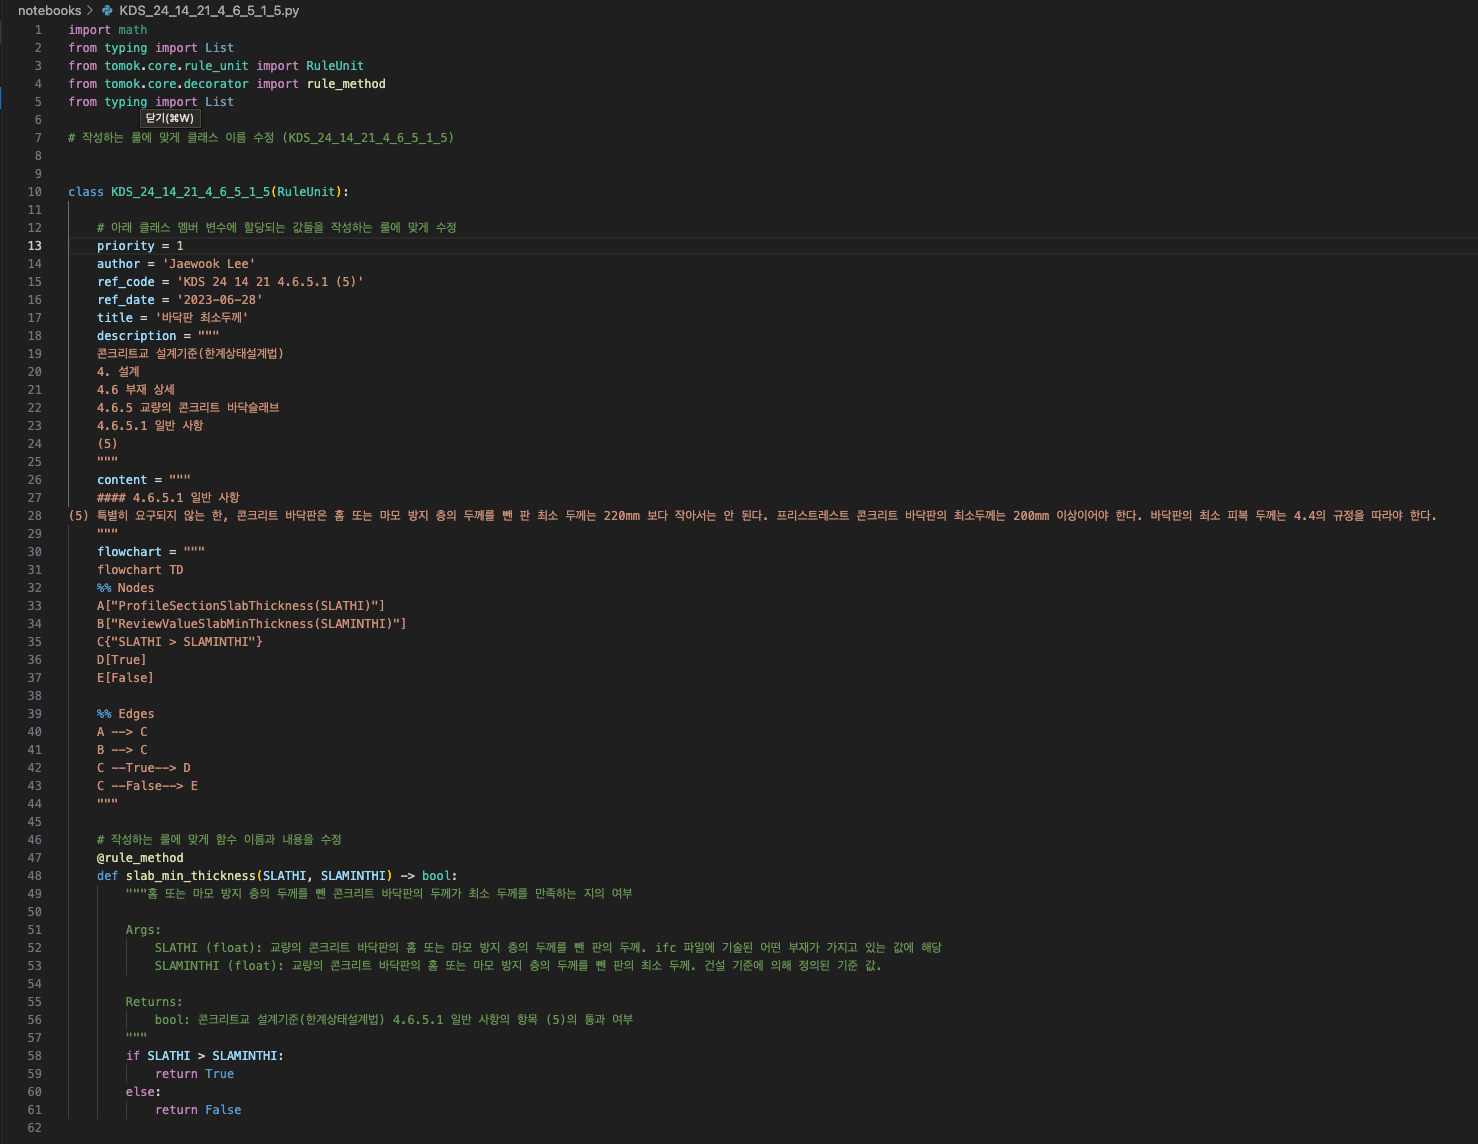

위와 같이 KDS_24_14_21_4_6_5_1_5.py를 작성하여 tomok/notebooks 폴더에 저장하였습니다.

해당 파일에 대한 설명은 이전에 배포해드렸던 RuleUnit 작성 예시 및 가이드라인 문서를 참고해주십시오.
<br><br>

RuleIFC 작성을 위해서 사전에 작성한 RuleUnit을 불러와 사용합니다.

KDS 24 14 21 4.6.4.1 (5)를 검토하는 RuleIFC는 아래와 같이 작성할 수 있습니다.

(작업자가 새로운 RuleIFC 작성을 위해 수정해야 할 부분은 아래의 코드에서 주석으로 표기하였습니다.)

In [72]:
from tomok.core.rule_ifc import RuleIFC
from tomok.ifc.reader import IFCReader
from tomok.ifc.entity import Product
from notebooks.KDS_24_14_21_4_6_5_1_5 import KDS_24_14_21_4_6_5_1_5
from tomok.core.util import *
from typing import List

# 23.10.24 - 기존에는 IFCReader가 부재 종류를 기반으로 타겟 부재를 검색하였으나, guid를 기반으로 타겟 부재를 검색하도록 변경되었습니다.
#            이에 따라 RuleIFC 클래스 호출 및 부재 검색에 사용되는 인자가 바뀌었으니 참고 부탁드립니다.

# 실제 RuleIFC 작성 시 클래스 명을 임의로 수정하시면 됩니다.
class RuleIFC_KDS_24_14_21_4_6_2_1_5(RuleIFC):
    # RuleIFC에서 검토할 RuleUnit을 이 부분에서 불러옵니다.
    ruleunit_1 = KDS_24_14_21_4_6_5_1_5()

    def __init__(self,
                 reader: IFCReader):
        self.reader = reader

    # 실제 RuleIFC 작성 시 수정해야 할 부분입니다.
    # IFC 파일에서 guid를 기반으로 부재를 검색하는 부분입니다.
    def retrieve_entities(
        self,
        guid: str):
        logging_normal(content=f"Target GUID: {guid}", tag="SEARCH")
        self.reader.get_products()
        try:
            target_entitiy = [self.reader.get_product_by_guid(guid)]
            logging_info(content="retrieved entity = {}".format(target_entitiy), tag="FIND")
        except:
            logging_info(content="Target Entity NOT FOUND!!!", tag="ALART")
            return []
        return target_entitiy

    # 실제 RuleIFC 작성 시 수정해야 할 부분입니다.
    # RuleIFC에서 불러온 부재들에 적용할 기준을 작성하는 부분입니다.
    # 작성될 내용은 RuleIFC로 구현하는 건설기준에 따라 상이합니다.
    def process(cls,
                entity: Product,
                ):
        # 본 예제에서는, 바닥판의 최소 두께에 대한 기준을 검토하므로 ifc 파일에서 해당 값을 가져와 RuleUnit의 실행 함수에 전달합니다.
        ruleunit_name = cls.ruleunit_1.ref_code
        logging_normal("{}".format(ruleunit_name))
        try:
            psets = entity.get_psets() # entity의 pset 가져오기
            for pset in psets:
                if pset.has_property("ReviewValueSlabMinThickness"): # 최소 두께 값 찾아서 
                    SLAMINTHI = pset.ReviewValueSlabMinThickness
                    print(SLAMINTHI)
            
            psets = entity.IfcProfileDef.get_psets()
            for pset in psets: 
                if pset.has_property("ProfileSectionSlabThickness"):
                    SLATHI = pset.ProfileSectionSlabThickness
                    print(SLATHI)

            result = cls.ruleunit_1.slab_min_thickness(SLATHI, SLAMINTHI)
            if result:
                logging_clear(content="SLATHI={} / SLAMINTHI={} ... PASSED".format(SLATHI, SLAMINTHI), tag="RESULT")
            # 실행 결과는 통과했는지에 대한 여부를 True or False로 반환합니다.
            return result
        except:
            logging_warn(content="FAILED", tag="RESULT")
            return False

작성한 RuleIFC는 아래의 코드와 같이 불러와서 테스트를 해 볼 수 있습니다.

이전 버전과 달리, RuleIFC 객체를 생성할 때, IFCReader를 인자로 함께 전달합니다.

In [88]:
temp_ruleifc = RuleIFC_KDS_24_14_21_4_6_2_1_5(
    reader=IFCReader("/Users/jaewooklee/Documents/Github/tomok/tomok/notebooks/PSC_girder_bridge_updated03.ifc")
)

In [89]:
temp_ruleifc.reader.get_products()

[#100=IfcBuilding('2NVkUgEgnAURvKxetlfdZx',#20,'',$,$,#16,$,'',.ELEMENT.,$,$,#99),
 #103=IfcBuildingStorey('3Zu5Bv0LOHrPC10026FoQQ',#20,'1F',$,'레벨:삼각형 헤드',#102,$,'1F',.ELEMENT.,0.),
 #114=IfcSite('2NVkUgEgnAURvKxetlfdZu',#20,'Default',$,$,#113,$,$,.ELEMENT.,(37,33,59,529418),(126,58,40,678710),0.,$,$),
 #135=IfcSlab('3$Y1qZFGzBO9A70r9J2$f$',#20,'바닥:slab_240T:378778',$,'바닥:slab_240T',#119,#134,'378778',.FLOOR.),
 #174=IfcSlab('3$Y1qZFGzBO9A70r9J2$et',#20,'바닥:slab_240T:378834',$,'바닥:slab_240T',#161,#173,'378834',.FLOOR.),
 #207=IfcSlab('3$Y1qZFGzBO9A70r9J2$Nl',#20,'바닥:slab_240T:378890',$,'바닥:slab_240T',#194,#206,'378890',.FLOOR.),
 #240=IfcSlab('3$Y1qZFGzBO9A70r9J2$Md',#20,'바닥:slab_240T:378946',$,'바닥:slab_240T',#227,#239,'378946',.FLOOR.),
 #273=IfcSlab('3$Y1qZFGzBO9A70r9J2$MV',#20,'바닥:slab_240T:379002',$,'바닥:slab_240T',#260,#272,'379002',.FLOOR.),
 #318=IfcBeam('3$Y1qZFGzBO9A70r9J2$8q',#20,'거더01:거더01:380881',$,'거더01:거더01',#317,#314,'380881',.BEAM.),
 #366=IfcBeam('3$Y1qZFGzBO9A70r9J2zdP

아래와 같이 특정 Ifc 파일을 읽기 위한 IFCReader를 전달하여, 대상이 되는 부재의 목록을 찾아올 수 있습니다.

In [94]:
entities = temp_ruleifc.retrieve_entities(
    guid='3$Y1qZFGzBO9A70r9J2$Md'
)

[ 23-11-03 18:41:30 ] SEARCH: Target GUID: 3$Y1qZFGzBO9A70r9J2$Md
[ 23-11-03 18:41:30 ] FIND: retrieved entity = [#240=IfcSlab('3$Y1qZFGzBO9A70r9J2$Md',#20,'바닥:slab_240T:378946',$,'바닥:slab_240T',#227,#239,'378946',.FLOOR.)]


IFCReader가 ifc 파일에서 guid를 통해 타겟 부재를 찾았습니다.

아래와 같이, ifc 파일 내에 작성된 부재에 대해 작업자가 작성한 RuleIFC의 process 단계를 적용하여 검토할 수 있습니다.

In [95]:
for entity in entities:
    print(entity)
    temp_ruleifc.process(entity) # entity가 process를 통과했는지의 여부(Bool type)

#240=IfcSlab('3$Y1qZFGzBO9A70r9J2$Md',#20,'바닥:slab_240T:378946',$,'바닥:slab_240T',#227,#239,'378946',.FLOOR.)
[ 23-11-03 18:41:32 ] : KDS 24 14 21 4.6.5.1 (5)
None
240.0
[ 23-11-03 18:41:32 ] RESULT: FAILED


In [96]:
entity.get_props()

{'ReviewResultSLS': {'ReviewResultSLSMinRebarArea': {'value': None,
   'descriptions': 'KDS 24 14 21 4.2.3.2'},
  'ReviewResultSLSCracking': {'value': None,
   'descriptions': 'KDS 24 14 21 4.2.3.3 (2)'},
  'ReviewResultSLSDeflection': {'value': None,
   'descriptions': 'KDS 24 14 21 4.2.4.2'}},
 'Pset_ReinforcementBarPitchOfSlab': {'Reference': {'value': 'slab_240T',
   'descriptions': None}},
 'Pset_SlabCommon': {'Reference': {'value': 'slab_240T', 'descriptions': None},
  'PitchAngle': {'value': 0.0, 'descriptions': None},
  'IsExternal': {'value': False, 'descriptions': None},
  'LoadBearing': {'value': False, 'descriptions': None}},
 'ReviewValue': {'ReviewValueULSMinRebarArea': {'value': None,
   'descriptions': None},
  'ReviewValueULSMaxLongitudinalRebarSpace': {'value': None,
   'descriptions': None},
  'ReviewValueULSMaxNeutralAxis': {'value': None, 'descriptions': None},
  'ReviewValueULSMaxDistributionRebarSpace': {'value': None,
   'descriptions': None},
  'ReviewValueULSM